In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.core.pylabtools as pylabtools # for figsize
import seaborn as sns



def mask_data(data,*args):
    mask_and=np.array(args).all(0)
    return data[mask_and]

/Users/borundev/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Time series analysis: No external data

In [3]:
data=pd.read_csv("processed_data.csv")
data['date']=pd.to_datetime(data.date)

# uncomment if we want to turn literal categorical values to numerical ones
# BEWARE that the things like the date in original data get affected by this
# better do it by hand for the ones that require it
#for col_name,col_data in data.iteritems():
#    if col_data.dtype == 'O':
#        data[col_name],tmp_indexer=pd.factorize(data[col_name])

/Users/borundev/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (16,17,19,24,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# since we want to make a time series in hours we need to make each "observation" or row correspond to a unique "hour"

data['delta_date']=(data.date-data.date[0])
data['delta_date']=map(lambda x : x.days,data.delta_date)

data['delta_time']=data.delta_date*24+data.time
data['delta_time']=map(lambda x: int(x),data.delta_time)

# since the original time includes minutes and we do not care about it we floor it
data['time_bin']=map(lambda x: int(x),data.time)

In [4]:
# For a time series analysis we cannot use other variables not related to date (we could include time and make the 
# intervals in hours instead of day but ultimatel the only fundamental information). Of course we can later add variables
# like the weather that are functions of the date

# If we want to analyze locations  (u'SECT_GEO_PEC', u'SECT_GEO_2_PEC') for instance we will have to do individual time series
# If we suspect cross correlations (and I don't) we could then look for those.


# create a new data frame that has the total calls for given unique hour given by 'delta_time' i.e. number of hours
# since the beginnning of the data set

columns_to_use=['date','month','day','time_bin','delta_date','delta_time'] 
nd=pd.DataFrame({'total' : data.groupby( columns_to_use).size()}).reset_index()


In [5]:
# since everything is identified by 'delta_time' we make it the index
nd=nd.set_index('delta_time')

# and since some data must be missing we need to reindex
nd=nd.reindex(range(nd.index.max()+1))

# and check if something is missing
nd.head(10)

,date,month,day,time_bin,delta_date,total
delta_time,,,,,,
0,2004-01-01,1,3,0,0,6
1,2004-01-01,1,3,1,0,6
2,2004-01-01,1,3,2,0,2
3,2004-01-01,1,3,3,0,3
4,2004-01-01,1,3,4,0,2
5,2004-01-01,1,3,5,0,3
6,2004-01-01,1,3,6,0,1
7,2004-01-01,1,3,7,0,4
8,NaT,NaN,NaN,NaN,NaN,NaN


In [6]:
# we now fill in the empty rows date, month, day and time_bin all uniquely identified by the index which is delta_time

start_date=nd.iloc[0].date

for index in nd[pd.isnull(nd.date)].index:
    nd.loc[index,'date']=start_date+pd.Timedelta(days=index/24)
    nd.loc[index,'month']=nd.loc[index,'date'].month
    nd.loc[index,'day']=pd.datetime.weekday(nd.loc[index,'date'])
    nd.loc[index,'time_bin']=np.mod(index,24)

nd['delta_date']=nd.index/24

In [7]:
# Now we impute the missing values for total. This is NOT the best way to do it. We could take averages
# based on week and time of day for instance

nd.loc[nd.total.isnull(),'total']=int(nd.total.mean()) # should have a better way to impute

In [8]:
# check that the missing values are filled
nd.head(10)

,date,month,day,time_bin,delta_date,total
delta_time,,,,,,
0,2004-01-01,1,3,0,0,6
1,2004-01-01,1,3,1,0,6
2,2004-01-01,1,3,2,0,2
3,2004-01-01,1,3,3,0,3
4,2004-01-01,1,3,4,0,2
5,2004-01-01,1,3,5,0,3
6,2004-01-01,1,3,6,0,1
7,2004-01-01,1,3,7,0,4
8,2004-01-01,1,3,8,0,3


In [9]:
# we drop delta_time and delta_date as we do not need them anymore. In principle we do not need 'date' anymore either
# but we keep it just to make sure nothing has gotten scrambled at some later point
nd=nd.reset_index()
nd_cleaned=nd.drop(['delta_date'],axis=1)

In [10]:
nd_cleaned.head()

,delta_time,date,month,day,time_bin,total
0,0,2004-01-01,1,3,0,6
1,1,2004-01-01,1,3,1,6
2,2,2004-01-01,1,3,2,2
3,3,2004-01-01,1,3,3,3
4,4,2004-01-01,1,3,4,2


In [11]:
nd.month=nd.month.astype(int)
nd.day=nd.day.astype(int)
nd.time_bin=nd.time_bin.astype(int)

In [12]:
# at this processed data so as not to have to do it again
nd.to_csv("classification_by_hour_data.csv",index=False)

In [13]:
# if nothing is changed above we start from here
nd=pd.read_csv("classification_by_hour_data.csv")

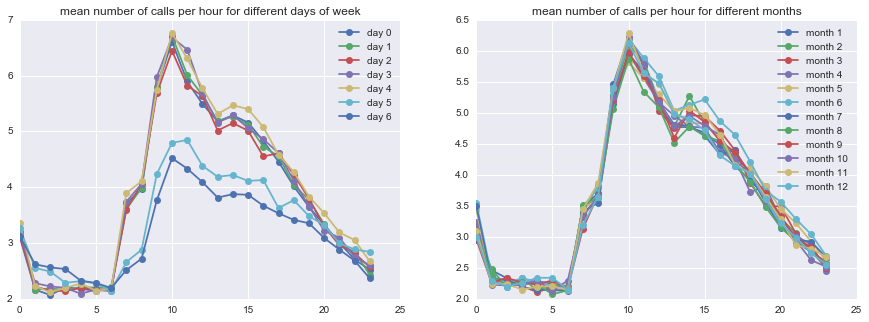

In [15]:
# we plot the behavior of mean number of calls by the hour for weekdays and months

pylabtools.figsize(15,5)
plt.subplot(121)
nd_mean=nd_cleaned.groupby(['day','time_bin']).mean().reset_index().drop('month',axis=1)
for i in range(7):
    data_masked=mask_data(nd_mean,nd_mean.day==i)
    plt.plot(data_masked.time_bin,data_masked.total,"-o",label="day "+str(i))
plt.title("mean number of calls per hour for different days of week")
plt.legend()

plt.subplot(122)
nd_mean=nd_cleaned.groupby(['month','time_bin']).mean().reset_index().drop('day',axis=1)
for i in range(1,13):
    data_masked=mask_data(nd_mean,nd_mean.month==i)
    plt.plot(data_masked.time_bin,data_masked.total,"-o",label="month "+str(i))
plt.title("mean number of calls per hour for different months")
plt.legend()

In [16]:
# we calculate a dataframe with this information
nd_mean=nd_cleaned.groupby(['month','day','time_bin']).mean().reset_index().drop(['delta_time'],axis=1)

nd_mean.columns=['month','day','time_bin','mu']
nd_mean.head()

,month,day,time_bin,mu
0,1,0,0,2.822222
1,1,0,1,2.311111
2,1,0,2,2.200000
3,1,0,3,2.022222
4,1,0,4,2.088889


In [17]:
nd_cleaned.head()

,delta_time,date,month,day,time_bin,total
0,0,2004-01-01,1,3,0,6
1,1,2004-01-01,1,3,1,6
2,2,2004-01-01,1,3,2,2
3,3,2004-01-01,1,3,3,3
4,4,2004-01-01,1,3,4,2


In [115]:
# merge the two data frame
nd_merged=nd_cleaned.merge(nd_mean,left_on=['month','day','time_bin'],right_on=['month','day','time_bin'])

In [116]:
# and see how it looks
nd_merged.sort_values(by='delta_time',inplace=True)
nd_merged.index=nd_merged.delta_time.values
nd_merged.head()

,delta_time,date,month,day,time_bin,total,mu
0,0,2004-01-01,1,3,0,6,3.045455
1,1,2004-01-01,1,3,1,6,2.363636
2,2,2004-01-01,1,3,2,2,2.386364
3,3,2004-01-01,1,3,3,3,2.113636
4,4,2004-01-01,1,3,4,2,2.204545


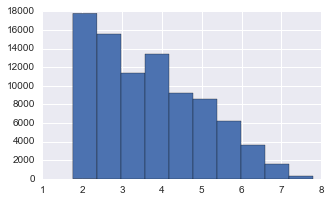

In [117]:
# How do we define 'busy'? It is a reasonable assumption that the distribution is a Poisson distribution

# The histogram of poission means is
pylabtools.figsize(5,3)
nd_merged.mu.hist()

In [118]:
# We see that in the range of interest 90% of cases fall within mu+.5 mu. So we define 'busy' as those that exceed this

[1.0*np.sum(np.random.poisson(i,10000)>(1.5*i))/10000 for i in range(2,9)]



[0.146, 0.1859, 0.1145, 0.1381, 0.0887, 0.0983, 0.064]

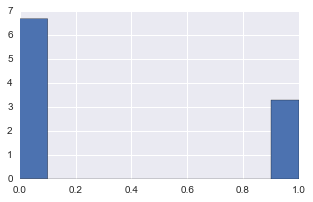

In [119]:

# another approach would be to ask if there is some persistance in the hours that see above average and those that see belo
# this would be some ising model like clumpign of spins
# we will try this


nd_merged['busy']=(nd_merged.total-1.2*nd_merged.mu>0).astype(int)

# this gives about 15% of the days busy. if this doesn't 'feel' right we can reduce the threshold to increase
# the number of days classified as busy
nd_merged['busy'].hist(normed='True')

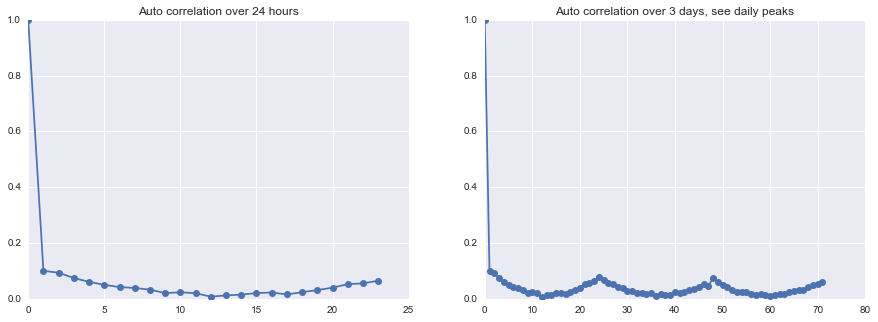

In [120]:
# Now we can test Niquille's intuition. He seems to claim busy hours come in chunks. That should mean that there
# should be correlations over the first few hours. However we fail to see this.


pylabtools.figsize(15,5)
plt.subplot(121)
autocorrelations=pd.Series([nd_merged.busy.autocorr(lag=l) for l in range(24)])
plt.plot(pd.rolling_mean(autocorrelations,1),"-o")
plt.title("Auto correlation over 24 hours")

plt.subplot(122)
autocorrelations=pd.Series([nd_merged.busy.autocorr(lag=l) for l in range(3*24)])
plt.plot(pd.rolling_mean(autocorrelations,1),"-o")

plt.title("Auto correlation over 3 days, see daily peaks")

In [121]:
total_lag_hours=24
for i in range(1,total_lag_hours+1):
    nd_merged['lag'+str(i)]=nd_merged.busy.shift(i)

cols=['lag'+str(i) for i in range(1,total_lag_hours+1) ]

In [122]:
# We cant use the first 'total_lag_days' as they do not have complete information accroding to the above model
nd_final=nd_merged[total_lag_hours:]

In [123]:
nd_final.head()

,delta_time,date,month,day,time_bin,total,mu,busy,lag1,lag2,...,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
24,24,2004-01-02,1,4,0,2,2.906977,0,0,0,...,0,0,0,0,1,0,1,0,1,1
25,25,2004-01-02,1,4,1,3,2.209302,1,0,0,...,0,0,0,0,0,1,0,1,0,1
26,26,2004-01-02,1,4,2,3,2.116279,1,1,0,...,0,0,0,0,0,0,1,0,1,0
27,27,2004-01-02,1,4,3,3,2.581395,0,1,1,...,0,0,0,0,0,0,0,1,0,1
28,28,2004-01-02,1,4,4,3,2.232558,1,0,1,...,0,0,0,0,0,0,0,0,1,0


In [124]:
y=nd_final.busy.values

In [125]:
X_numerical=nd_final[cols].values
X_categorical=nd_final[['day','month','time_bin']].values

In [126]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
enc.fit(X_categorical)
X_categorical=enc.transform(X_categorical).toarray()

In [127]:
X=np.hstack((X_numerical,X_categorical))

In [128]:
from sklearn.cross_validation import train_test_split

In [129]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [130]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [131]:
clf=ExtraTreesClassifier(n_estimators=200,n_jobs=-1)
#clf=LogisticRegression()
#clf=SVC()
clf.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [132]:
y_pred_rt = clf.predict_proba(X_test)[:, 1]

In [133]:
from sklearn.metrics import roc_curve
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

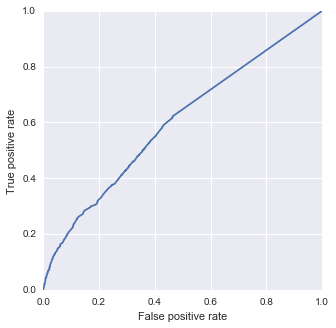

In [114]:
pylabtools.figsize(5,5)


plt.plot(fpr_rt_lm, tpr_rt_lm)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')